In [1]:
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display
import soundfile as sf
import matplotlib.patches as patch
import matplotlib.pyplot as plt
import IPython.display as ipd
from pathlib import Path
from tqdm.notebook import tqdm
from scipy.io import wavfile
import time
import os
import shutil
from skimage import io
from skimage.color import rgb2gray,rgba2rgb
#https://github.com/iver56/audiomentations ?
%matplotlib inline
CC_ROOT=Path("D:\\KidElectric\\rfcx_kaggle") #Cookiecutter datascience-style project
CC_DATA_OUT=CC_ROOT.joinpath('data').joinpath('interim')

DATA_ROOT = CC_ROOT.joinpath('data')
TRAIN_AUDIO_ROOT = DATA_ROOT.joinpath('raw').joinpath('train')#Update to point to cookiecutter data/raw/train
TEST_AUDIO_ROOT = DATA_ROOT.joinpath('raw').joinpath('test')#Update to point to cookiecutter data/raw/test


df_train = pd.DataFrame({
    "recording_id": [path.stem for path in TRAIN_AUDIO_ROOT.glob("*.flac")],
})

df_test = pd.DataFrame({
    "recording_id": [path.stem for path in TEST_AUDIO_ROOT.glob("*.flac")],
})

df_tp=pd.read_csv(CC_ROOT.joinpath('references').joinpath('train_tp.csv')).set_index('recording_id')

df_fp=pd.read_csv(CC_ROOT.joinpath('references').joinpath('train_fp.csv')).set_index('recording_id')


In [19]:
class params:
    """
    Parameters used for generating spectrograms from audio data
    """
    sr = 48000 #sampling rate

    # Melspectrogram
    n_mels = 128
    fmin = 80
    fmax = 14000  
    n_fft=2048
    hop_length = 512
    
def load_audio(pnfn="", sr=48000):
    y, _ = lb.load(pnfn,
        sr=sr, 
    )
    return y

def compute_melspec(y, params):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = lb.feature.melspectrogram(
        y, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax, hop_length=params.hop_length,n_fft=params.n_fft
    )
    melspec = lb.power_to_db(melspec).astype(np.float32)
    return melspec

def foreground_background_trfm(y):
    """ Computes foreground / background spectral separation
        Arguments:
        y {np array} -- signal
        
    """
    S_full, phase = lb.magphase(librosa.stft(y))
    
    # Try librosa segmentation example:
    S_filter = lb.decompose.nn_filter(S_full,
                                           aggregate=np.median,
                                           metric='cosine',
                                           width=int(lb.time_to_frames(2, sr=params.sr)))

    # The output of the filter shouldn't be greater than the input
    # if we assume signals are additive.  Taking the pointwise minimium
    # with the input spectrum forces this.
    S_filter = np.minimum(S_full, S_filter)    
    margin_i, margin_v = 2, 10
    power = 2
    mask_i = librosa.util.softmask(S_filter,
                                   margin_i * (S_full - S_filter),
                                   power=power)

    mask_v = librosa.util.softmask(S_full - S_filter,
                                   margin_v * S_filter,
                                   power=power)

    # Once we have the masks, simply multiply them with the input spectrum
    # to separate the components

    S_foreground = mask_v * S_full
    S_background = mask_i * S_full
    return S_full, S_foreground, S_background

def make_box(df_tp,recording):
    t_start=df_tp['t_min'][recording]
    t_stop= df_tp['t_max'][recording]
    f_min= df_tp['f_min'][recording]
    f_max= df_tp['f_max'][recording]
    #matplotlib.patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
    width=t_stop-t_start
    height=f_max-f_min
    xy=(t_start,f_min)
    return t_start, t_stop, f_min, f_max

def has_tp_fp(rec,df_tp,df_fp):
    #Many recordings have both tp and fp data labeled.
    has_tp=False
    has_fp=False
    if rec in df_tp.index:
        has_tp = True
    if rec in df_fp.index:
        has_fp = True
    return has_tp, has_fp

def clip_info(rec,df):
    keep={'species_id':[],'t_min':[],'t_max':[]}
    for key in df.keys():
        if key in keep.keys():
            if isinstance(df[key][rec],pd.core.series.Series):
                keep[key]=[val for val in df[key][rec].values]
            else:
                keep[key].append(df[key][rec])
    return keep

def clip_identity(rec,df_tp,df_fp,start,stop):
    out={'tp_spec':[],'tp':0,
         'fp_spec':[],'fp':0}
    has_fp=False
    has_tp=False
    if rec in df_tp.index:
        info = clip_info(rec,df_tp)
        for i,spec in enumerate(info['species_id']):
            t_min=info['t_min'][i]
            t_max=info['t_max'][i]
            overlap=(t_min < stop and t_min >= start) or (t_max >= start and t_max < stop)
            if overlap == True:
                has_tp=True
                out['tp_spec'].append(spec)
                out['tp']+=1
    
    if rec in df_fp.index:
        info = clip_info(rec,df_fp)
        for i,spec in enumerate(info['species_id']):
            t_min=info['t_min'][i]
            t_max=info['t_max'][i]
            overlap=(t_min < stop and t_min >= start) or (t_max >= start and t_max < stop)
            if overlap == True:
                has_fp=True
                out['fp_spec'].append(spec + 24)
                out['fp']+=1   
    return out

def subtract_median(med,melspec):
    med_sub=np.zeros(melspec.shape)
    for i,col in enumerate(melspec.transpose()):
        med_sub[:,i]=col-med 
    return med_sub

def plot_and_save(dat,params):
        idx=params.idx
        params.ax=[]
        for i in range(0,3,1):
            ax=plt.subplot(3,1,i+1)
            params.ax.append(ax)
            ax.axis('off') 
            ax.xaxis.set_major_locator(plt.NullLocator())
            ax.yaxis.set_major_locator(plt.NullLocator())
        plt.subplots_adjust(wspace=0, hspace=0)
        for i,d in enumerate(dat):
            lb.display.specshow(lb.amplitude_to_db(d[:, idx], ref=np.max),
                                y_axis='log', sr=params.sr, ax=params.ax[i])

        img_pnfn=params.img_pnfn
        print('\tSaving to %s' % img_pnfn)
        plt.savefig(img_pnfn, pad_inches=0, bbox_inches='tight', transparent=True)
        time.sleep(0.1)
        plt.clf()
        
def save_spectrum_image(y,params,df_tp,df_fp):
    fs=params.sr
    use_root=params.use_root
    print('\t Separating foreground from background...')
    full,fore,back = foreground_background_trfm(y)
    dat=[full,fore,back]
    print('\t Separated! Plotting...')
    # Make spectrogram clips:
    for c,i in enumerate(range(0,params.rec_length,params.clip_dur)):
        start=i
        stop=i+params.clip_dur
        params.idx = slice(*lb.time_to_frames([start,stop], sr=params.sr))
        save_clip=False
        if params.mode == 'TRAIN':            
            clip_id=clip_identity(params.fn,df_tp,df_fp,start,stop)
            if clip_id['tp'] == 1:
                #If clip has one true positive, label that species:
                img_fn='TP_%s_%s_%d.png' % (clip_id['tp_spec'][0],params.fn,c)
                save_clip = False
            if clip_id['tp'] == 0 and clip_id['fp']>=1:
                #If clip has no true positives and at least 1 false positive, label as first false positive species:
                img_fn='FP_%s_%s_%d.png' % (clip_id['fp_spec'][0],params.fn,c)
                save_clip = False #Temp
            if clip_id['tp'] == 0 and clip_id['fp']==0:
                #If clip has no TP or FP, label as a unique species id 99:
                img_fn='NP_%s_%s_%d.png' % ('98',params.fn,c)
                save_clip = True # Exclude empty clips for now...
        elif params.mode == 'TEST':
            img_fn='%s_%d' % (params.fn,c)
            save_clip=True
       
        if save_clip == True: 
            params.img_pnfn=params.dest.joinpath(img_fn)
            plot_and_save(dat,params)




In [ ]:
# Make spectrum for each species in recording in train/test:
fig=plt.figure(figsize=(12, 8))


modes = ['TRAIN']
params.clip_dur=6 # second chunks
params.tp_limit=1 # 1TP max per clip

for mode in modes:
    if mode == 'TEST':
        resume=0
        use_df=df_test
        use_root=TEST_AUDIO_ROOT 
        params.dest=DATA_ROOT.joinpath('interim').joinpath('test').joinpath('clip_decomp')
    elif mode == 'TRAIN':
        resume=0
        use_df=df_train
        use_root=TRAIN_AUDIO_ROOT
        params.dest=DATA_ROOT.joinpath('interim').joinpath('train').joinpath('clip_decomp')
    params.use_root=use_root
       
    if params.dest.exists() == False:
        os.mkdir(params.dest)
    for ii,fn in enumerate(use_df['recording_id'][resume:]):
        pnfn=use_root.joinpath(fn).with_suffix(".flac")
        _,fs=sf.read(pnfn)
        params.sr=fs
        params.mode=mode

        print('\n%d of %d. Loading...' % (resume+ii, len(use_df['recording_id'])))        
        params.fn=fn
        y = load_audio(pnfn, params.sr)
        print('\tLoaded.')
        params.rec_length=int(y.shape[0]/params.sr)
        save_spectrum_image(y,params,df_tp,df_fp)


0 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_00204008d_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_00204008d_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_00204008d_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_00204008d_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_00204008d_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_00204008d_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_00204008d_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_00204008d_9.png

1 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0099c367b_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0099c367b_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0099c367b_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0099c367b_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0099c367b_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0099c367b_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0099c367b_7.png

11 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_009aa1c8f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_009aa1c8f_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_009aa

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_011f25080_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_011f25080_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_011f25080_9.png

20 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_013716dbf_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_013716dbf_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_013716dbf_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_013716dbf_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_013716dbf_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_013716dbf_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_01371

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_01a976045_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_01a976045_9.png

30 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_01b41f92b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_01b41f92b_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_01b41f92b_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_01b41f92b_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_01b41f92b_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_01b41f92b_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_01b41f92b_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_01b41

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_023e22a5e_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_023e22a5e_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_023e22a5e_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_023e22a5e_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_023e22a5e_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_023e22a5e_8.png

41 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0268057eb_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0268057eb_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0268057eb_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_02680

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0319f2979_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0319f2979_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0319f2979_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0319f2979_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0319f2979_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0319f2979_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0319f2979_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0319f2979_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0319f2979_9.png

52 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_032cb

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_039dd83e7_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_039dd83e7_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_039dd83e7_8.png

62 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_03a7d9ad6_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_03a7d9ad6_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_03a7d9ad6_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_03a7d9ad6_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_03a7d9ad6_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_03a7d9ad6_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_03a7d

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_042638dad_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_042638dad_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_042638dad_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_042638dad_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_042638dad_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_042638dad_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_042638dad_9.png

73 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_043356ff8_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_043356ff8_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_04335

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_049a76094_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_049a76094_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_049a76094_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_049a76094_9.png

83 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_049bbf288_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_049bbf288_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_049bbf288_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_049bbf288_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_049bbf288_9.png

84 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Se


93 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_04fb46abf_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_04fb46abf_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_04fb46abf_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_04fb46abf_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_04fb46abf_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_04fb46abf_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_04fb46abf_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_04fb46abf_9.png

94 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\N


103 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_055d22517_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_055d22517_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_055d22517_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_055d22517_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_055d22517_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_055d22517_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_055d22517_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_055d22517_9.png

104 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_065012e32_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_065012e32_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_065012e32_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_065012e32_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_065012e32_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_065012e32_9.png

114 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_06523229a_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_06523229a_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_06523229a_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0652

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_06c44d203_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_06c44d203_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_06c44d203_9.png

124 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_06d8a3bae_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_06d8a3bae_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_06d8a3bae_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_06d8a3bae_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_06d8a3bae_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_06d8a3bae_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_06d8

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_072394f9f_9.png

134 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_073e4d908_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_073e4d908_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_073e4d908_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_073e4d908_7.png

135 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_074978766_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_074978766_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_074978766_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_07b5f24b6_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_07b5f24b6_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_07b5f24b6_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_07b5f24b6_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_07b5f24b6_9.png

145 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_07c08e332_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_07c08e332_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_07c08e332_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_07c08e332_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_07c0


154 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0819bd965_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0819bd965_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0819bd965_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0819bd965_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0819bd965_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0819bd965_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0819bd965_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0819bd965_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0819bd965_9.png

155 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 


164 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_088a32d3e_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_088a32d3e_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_088a32d3e_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_088a32d3e_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_088a32d3e_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_088a32d3e_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_088a32d3e_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_088a32d3e_7.png

165 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_091a9a48c_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_091a9a48c_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_091a9a48c_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_091a9a48c_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_091a9a48c_9.png

175 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_091d8cc72_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_091d8cc72_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_091d8cc72_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_091d8cc72_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_091d

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_09a946316_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_09a946316_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_09a946316_7.png

186 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_09bb67de8_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_09bb67de8_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_09bb67de8_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_09bb67de8_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_09bb67de8_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_09bb67de8_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_09bb

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0a4f02024_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0a4f02024_9.png

196 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0a65cc78c_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0a65cc78c_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0a65cc78c_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0a65cc78c_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0a65cc78c_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0a65cc78c_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0a65cc78c_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0a65

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0ab6aa734_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0ab6aa734_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0ab6aa734_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0ab6aa734_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0ab6aa734_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0ab6aa734_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0ab6aa734_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0ab6aa734_9.png

207 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0ad908b48_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0ad9


217 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0b5a33bb8_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0b5a33bb8_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0b5a33bb8_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0b5a33bb8_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0b5a33bb8_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0b5a33bb8_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0b5a33bb8_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0b5a33bb8_9.png

218 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c06d49cb_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c06d49cb_9.png

227 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c07848ae_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c07848ae_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c07848ae_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c07848ae_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c07848ae_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c07848ae_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c07848ae_9.png

228 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c8072185_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c8072185_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c8072185_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c8072185_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c8072185_7.png

237 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c8324b42_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c8324b42_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c8324b42_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c8324b42_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0c83

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0cd206677_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0cd206677_9.png

246 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0cf1a2ecd_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0cf1a2ecd_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0cf1a2ecd_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0cf1a2ecd_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0cf1a2ecd_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0cf1a2ecd_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0cf1a2ecd_7.png

247 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0d4a24cc8_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0d4a24cc8_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0d4a24cc8_9.png

256 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0d503b7e8_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0d503b7e8_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0d503b7e8_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0d503b7e8_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0d503b7e8_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0d503b7e8_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0d50

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0dd5a2bdb_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0dd5a2bdb_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0dd5a2bdb_9.png

266 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0de868a8d_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0de868a8d_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0de868a8d_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0de868a8d_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0de868a8d_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0de868a8d_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0de8

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e2e4ac19_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e2e4ac19_9.png

276 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e30535d1_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e30535d1_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e30535d1_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e30535d1_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e30535d1_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e30535d1_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e30535d1_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e30

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e85a95f7_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e85a95f7_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e85a95f7_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e85a95f7_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e85a95f7_8.png

286 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e952fb8a_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e952fb8a_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e952fb8a_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e952fb8a_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0e95

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f00a85fd_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f00a85fd_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f00a85fd_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f00a85fd_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f00a85fd_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f00a85fd_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f00a85fd_9.png

296 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f08c882f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f08c882f_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f08

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f99800b7_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f99800b7_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f99800b7_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f99800b7_9.png

306 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f9fcb0c4_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f9fcb0c4_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f9fcb0c4_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f9fcb0c4_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f9fcb0c4_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_0f9f

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1014e6d3e_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1014e6d3e_5.png

316 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1028dc3ed_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1028dc3ed_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1028dc3ed_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1028dc3ed_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1028dc3ed_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1028dc3ed_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1028dc3ed_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1028

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_10dae79ed_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_10dae79ed_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_10dae79ed_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_10dae79ed_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_10dae79ed_9.png

326 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_10debeacf_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_10debeacf_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_10debeacf_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_10debeacf_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_10de

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_11246c3ec_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_11246c3ec_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_11246c3ec_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_11246c3ec_9.png

336 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_113a2c172_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_113a2c172_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_113a2c172_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_113a2c172_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_113a2c172_9.png

337 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_11fd2b63e_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_11fd2b63e_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_11fd2b63e_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_11fd2b63e_9.png

347 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1217fa38e_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1217fa38e_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1217fa38e_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1217fa38e_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1217fa38e_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1217

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_12ac9ebdb_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_12ac9ebdb_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_12ac9ebdb_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_12ac9ebdb_9.png

357 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_12c6e385e_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_12c6e385e_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_12c6e385e_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_12c6e385e_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_12c6e385e_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_12c6

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_133001416_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_133001416_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_133001416_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_133001416_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_133001416_9.png

367 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_134c64639_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_134c64639_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_134c64639_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_134c64639_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_134c

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_13ccbd76b_8.png

377 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_13de5cabb_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_13de5cabb_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_13de5cabb_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_13de5cabb_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_13de5cabb_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_13de5cabb_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_13de5cabb_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_13de5cabb_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_13de

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_143674b5d_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_143674b5d_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_143674b5d_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_143674b5d_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_143674b5d_8.png

387 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1441fe517_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1441fe517_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1441fe517_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1441fe517_9.png

388 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_14948ff80_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_14948ff80_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_14948ff80_9.png

397 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1498304c0_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1498304c0_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1498304c0_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1498304c0_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1498304c0_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1498304c0_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1498

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_14d2427dd_9.png

407 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_14d467153_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_14d467153_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_14d467153_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_14d467153_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_14d467153_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_14d467153_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_14d467153_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_14d467153_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_14d4

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_15392c97b_9.png

417 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1543fd460_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1543fd460_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1543fd460_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1543fd460_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1543fd460_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1543fd460_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1543fd460_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1543fd460_9.png

418 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_15bc6e498_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_15bc6e498_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_15bc6e498_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_15bc6e498_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_15bc6e498_9.png

427 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_15d9e6d8b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_15d9e6d8b_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_15d9e6d8b_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_15d9e6d8b_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_15d9

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_163fcf5f0_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_163fcf5f0_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_163fcf5f0_9.png

437 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_16510f04f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_16510f04f_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_16510f04f_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_16510f04f_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_16510f04f_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_16510f04f_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1651

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_16ccddf71_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_16ccddf71_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_16ccddf71_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_16ccddf71_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_16ccddf71_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_16ccddf71_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_16ccddf71_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_16ccddf71_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_16ccddf71_9.png

448 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_176a47a27_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_176a47a27_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_176a47a27_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_176a47a27_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_176a47a27_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_176a47a27_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_176a47a27_9.png

458 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_177389698_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_177389698_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1773

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_17b6d882e_9.png

469 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_17bbe2cc4_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_17bbe2cc4_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_17bbe2cc4_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_17bbe2cc4_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_17bbe2cc4_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_17bbe2cc4_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_17bbe2cc4_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_17bbe2cc4_9.png

470 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_181a23783_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_181a23783_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_181a23783_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_181a23783_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_181a23783_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_181a23783_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_181a23783_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_181a23783_9.png

480 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1821c718c_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra


489 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_18d1e6ea1_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_18d1e6ea1_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_18d1e6ea1_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_18d1e6ea1_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_18d1e6ea1_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_18d1e6ea1_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_18d1e6ea1_9.png

490 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_18de8abcc_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1958ed85a_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1958ed85a_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1958ed85a_9.png

499 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_19599b9bc_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_19599b9bc_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_19599b9bc_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_19599b9bc_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_19599b9bc_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_19599b9bc_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1959

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_19a612a4a_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_19a612a4a_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_19a612a4a_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_19a612a4a_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_19a612a4a_7.png

509 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_19b189d6e_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_19b189d6e_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_19b189d6e_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_19b189d6e_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_19b1

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1a24795a3_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1a24795a3_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1a24795a3_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1a24795a3_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1a24795a3_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1a24795a3_9.png

519 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1a3993962_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1a3993962_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1a3993962_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1a39

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1adcfb22d_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1adcfb22d_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1adcfb22d_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1adcfb22d_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1adcfb22d_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1adcfb22d_9.png

530 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1aeb1e9e1_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1aeb1e9e1_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1aeb1e9e1_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1aeb

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1b77382c7_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1b77382c7_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1b77382c7_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1b77382c7_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1b77382c7_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1b77382c7_7.png

541 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1b90ba570_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1b90ba570_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1b90ba570_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1b90

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1c30a1874_7.png

551 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1c388423d_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1c388423d_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1c388423d_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1c388423d_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1c388423d_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1c388423d_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1c388423d_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1c388423d_9.png

552 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1cd3a6d11_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1cd3a6d11_9.png

561 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1ce06e027_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1ce06e027_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1ce06e027_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1ce06e027_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1ce06e027_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1ce06e027_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1ce06e027_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1ce0

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d2601f32_9.png

571 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d2ba4c81_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d2ba4c81_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d2ba4c81_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d2ba4c81_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d2ba4c81_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d2ba4c81_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d2ba4c81_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d2ba4c81_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d2b


581 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d8e04120_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d8e04120_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d8e04120_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d8e04120_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d8e04120_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d8e04120_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d8e04120_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d8e04120_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1d8e04120_9.png

582 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 


591 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1e379f7a6_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1e379f7a6_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1e379f7a6_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1e379f7a6_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1e379f7a6_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1e379f7a6_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1e379f7a6_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1e379f7a6_9.png

592 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1ea2f04c3_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1ea2f04c3_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1ea2f04c3_9.png

602 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1eb2a9113_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1eb2a9113_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1eb2a9113_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1eb2a9113_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1eb2a9113_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1eb2a9113_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1eb2

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1f17893f9_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1f17893f9_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1f17893f9_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1f17893f9_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1f17893f9_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1f17893f9_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1f17893f9_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1f17893f9_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1f17893f9_9.png

613 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1f979c4c5_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1f979c4c5_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1f979c4c5_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1f979c4c5_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1f979c4c5_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1f979c4c5_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1f979c4c5_9.png

622 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1fb27e574_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1fb27e574_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_1fb2

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_200656f13_9.png

632 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_200cf55d0_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_200cf55d0_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_200cf55d0_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_200cf55d0_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_200cf55d0_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_200cf55d0_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_200cf55d0_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_200cf55d0_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_200c

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_207c8241d_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_207c8241d_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_207c8241d_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_207c8241d_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_207c8241d_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_207c8241d_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_207c8241d_9.png

642 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_20801bb7d_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_20801bb7d_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2080

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2105bda77_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2105bda77_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2105bda77_9.png

652 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_211cde35f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_211cde35f_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_211cde35f_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_211cde35f_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_211cde35f_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_211cde35f_8.png

653 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_21ce5cb13_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_21ce5cb13_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_21ce5cb13_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_21ce5cb13_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_21ce5cb13_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_21ce5cb13_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_21ce5cb13_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_21ce5cb13_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_21ce5cb13_9.png

663 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra


672 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_22a2faf44_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_22a2faf44_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_22a2faf44_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_22a2faf44_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_22a2faf44_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_22a2faf44_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_22a2faf44_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_22a2faf44_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_22a2faf44_9.png

673 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2305471d3_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2305471d3_9.png

682 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2308ff2e5_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2308ff2e5_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2308ff2e5_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2308ff2e5_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2308ff2e5_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2308ff2e5_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2308ff2e5_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2308

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_236108ef3_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_236108ef3_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_236108ef3_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_236108ef3_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_236108ef3_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_236108ef3_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_236108ef3_9.png

693 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_237fc955f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_237fc955f_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_237f

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_241406d95_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_241406d95_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_241406d95_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_241406d95_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_241406d95_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_241406d95_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_241406d95_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_241406d95_9.png

704 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2433c9975_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2433

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_24ccd2df6_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_24ccd2df6_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_24ccd2df6_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_24ccd2df6_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_24ccd2df6_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_24ccd2df6_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_24ccd2df6_9.png

713 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_24d73a0c7_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_24d73a0c7_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_24d7

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_255893f95_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_255893f95_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_255893f95_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_255893f95_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_255893f95_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_255893f95_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_255893f95_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_255893f95_9.png

723 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_25619863c_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2561

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_25c862159_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_25c862159_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_25c862159_8.png

732 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_25d81e0f5_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_25d81e0f5_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_25d81e0f5_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_25d81e0f5_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_25d81e0f5_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_25d81e0f5_6.png

733 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_26ae2763d_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_26ae2763d_9.png

742 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_26c0b52fe_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_26c0b52fe_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_26c0b52fe_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_26c0b52fe_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_26c0b52fe_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_26c0b52fe_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_26c0b52fe_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_26c0

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2753487e1_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2753487e1_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2753487e1_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2753487e1_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2753487e1_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2753487e1_9.png

752 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_275a0fc0c_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_275a0fc0c_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_275a0fc0c_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_275a

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_281865590_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_281865590_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_281865590_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_281865590_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_281865590_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_281865590_9.png

762 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_28250a178_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_28250a178_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_28250a178_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2825

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_28d37d1de_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_28d37d1de_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_28d37d1de_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_28d37d1de_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_28d37d1de_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_28d37d1de_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_28d37d1de_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_28d37d1de_9.png

773 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_28d556f2e_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_29213ed4e_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_29213ed4e_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_29213ed4e_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_29213ed4e_9.png

783 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_29245287b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_29245287b_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_29245287b_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_29245287b_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_29245287b_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2924

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a1924793_9.png

793 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a1bb0557_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a1bb0557_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a1bb0557_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a1bb0557_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a1bb0557_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a1bb0557_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a1bb0557_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a1bb0557_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a1b

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a730c98d_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a730c98d_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a730c98d_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a730c98d_9.png

803 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a7ed55d4_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a7ed55d4_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a7ed55d4_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a7ed55d4_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a7ed55d4_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2a7e

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2b1b234ce_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2b1b234ce_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2b1b234ce_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2b1b234ce_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2b1b234ce_9.png

813 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2b60aa72c_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2b60aa72c_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2b60aa72c_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2b60aa72c_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2b60


823 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2bdde787f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2bdde787f_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2bdde787f_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2bdde787f_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2bdde787f_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2bdde787f_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2bdde787f_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2bdde787f_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2bdde787f_9.png

824 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2c77c2250_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2c77c2250_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2c77c2250_9.png

833 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2c8b3fa52_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2c8b3fa52_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2c8b3fa52_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2c8b3fa52_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2c8b3fa52_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2c8b3fa52_9.png

834 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2cf279c36_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2cf279c36_7.png

843 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2cf89ef6b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2cf89ef6b_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2cf89ef6b_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2cf89ef6b_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2cf89ef6b_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2cf89ef6b_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2cf89ef6b_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2cf8


853 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2d7f18f82_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2d7f18f82_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2d7f18f82_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2d7f18f82_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2d7f18f82_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2d7f18f82_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2d7f18f82_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2d7f18f82_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2d7f18f82_9.png

854 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2df1f109b_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2df1f109b_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2df1f109b_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2df1f109b_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2df1f109b_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2df1f109b_9.png

864 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2df3efc0a_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2df3efc0a_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2df3efc0a_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2df3

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2e6758f3e_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2e6758f3e_6.png

874 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2e698aba5_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2e698aba5_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2e698aba5_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2e698aba5_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2e698aba5_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2e698aba5_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2e698aba5_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2e69

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2edb76a28_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2edb76a28_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2edb76a28_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2edb76a28_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2edb76a28_9.png

884 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2ef429016_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2ef429016_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2ef429016_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2ef429016_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2ef4

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2f594b20f_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2f594b20f_9.png

894 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2f5d0583e_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2f5d0583e_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2f5d0583e_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2f5d0583e_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2f5d0583e_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2f5d0583e_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2f5d0583e_9.png

895 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2fe00fdac_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2fe00fdac_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2fe00fdac_9.png

904 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2fe8e5519_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2fe8e5519_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2fe8e5519_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2fe8e5519_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2fe8e5519_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2fe8e5519_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_2fe8

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_305ff00d1_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_305ff00d1_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_305ff00d1_9.png

914 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3064b6276_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3064b6276_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3064b6276_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3064b6276_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3064b6276_9.png

915 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_30f186665_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_30f186665_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_30f186665_9.png

924 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3101382bc_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3101382bc_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3101382bc_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3101382bc_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3101382bc_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3101382bc_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3101

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_31635c86c_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_31635c86c_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_31635c86c_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_31635c86c_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_31635c86c_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_31635c86c_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_31635c86c_9.png

934 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3181f8112_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3181f8112_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3181

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_31eb94279_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_31eb94279_9.png

943 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_321c09a90_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_321c09a90_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_321c09a90_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_321c09a90_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_321c09a90_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_321c09a90_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_321c09a90_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_321c

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_32af58c85_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_32af58c85_9.png

953 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_32c0ebf77_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_32c0ebf77_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_32c0ebf77_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_32c0ebf77_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_32c0ebf77_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_32c0ebf77_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_32c0ebf77_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_32c0


963 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_33d0f2685_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_33d0f2685_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_33d0f2685_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_33d0f2685_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_33d0f2685_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_33d0f2685_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_33d0f2685_7.png

964 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_33d5aebae_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3483217ab_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3483217ab_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3483217ab_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3483217ab_9.png

975 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_348e3f6db_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_348e3f6db_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_348e3f6db_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_348e3f6db_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_348e3f6db_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_351466c48_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_351466c48_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_351466c48_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_351466c48_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_351466c48_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_351466c48_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_351466c48_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_351466c48_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_351466c48_9.png

986 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tra

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_356b93991_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_356b93991_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_356b93991_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_356b93991_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_356b93991_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_356b93991_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_356b93991_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_356b93991_9.png

996 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_356fd5b86_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_356f

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_35f9c5c38_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_35f9c5c38_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_35f9c5c38_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_35f9c5c38_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_35f9c5c38_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_35f9c5c38_7.png

1006 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_35ff91122_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_35ff91122_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_35ff91122_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_35f

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_364e10d4b_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_364e10d4b_9.png

1016 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_364e9b5e7_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_364e9b5e7_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_364e9b5e7_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_364e9b5e7_9.png

1017 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_366fad396_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_366fad396_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_372a21fa4_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_372a21fa4_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_372a21fa4_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_372a21fa4_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_372a21fa4_9.png

1028 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_373ec0df1_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_373ec0df1_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_373ec0df1_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_373ec0df1_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_373

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_37d16f30f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_37d16f30f_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_37d16f30f_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_37d16f30f_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_37d16f30f_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_37d16f30f_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_37d16f30f_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_37d16f30f_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_37d16f30f_9.png

1039 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_38bbedd15_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_38bbedd15_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_38bbedd15_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_38bbedd15_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_38bbedd15_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_38bbedd15_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_38bbedd15_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_38bbedd15_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_38bbedd15_9.png

1049 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_398d2c4f1_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_398d2c4f1_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_398d2c4f1_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_398d2c4f1_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_398d2c4f1_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_398d2c4f1_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_398d2c4f1_9.png

1059 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_398e818ec_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_398e818ec_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_398

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3a2afcf76_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3a2afcf76_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3a2afcf76_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3a2afcf76_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3a2afcf76_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3a2afcf76_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3a2afcf76_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3a2afcf76_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3a2afcf76_9.png

1069 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3aae54bad_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3aae54bad_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3aae54bad_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3aae54bad_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3aae54bad_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3aae54bad_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3aae54bad_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3aae54bad_9.png

1079 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3ab39acdc_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3ab

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3b25a3af1_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3b25a3af1_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3b25a3af1_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3b25a3af1_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3b25a3af1_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3b25a3af1_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3b25a3af1_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3b25a3af1_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3b25a3af1_9.png

1090 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3bb222791_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3bb222791_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3bb222791_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3bb222791_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3bb222791_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3bb222791_9.png

1100 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3c1e77d9f_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3c1e77d9f_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3c1e77d9f_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3c1

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3c5d6f23a_8.png

1110 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3c621e663_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3c621e663_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3c621e663_7.png

1111 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3c65dc905_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3c65dc905_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3c65dc905_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3c65dc905_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3cf0187e0_9.png

1121 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3d19d7bb0_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3d19d7bb0_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3d19d7bb0_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3d19d7bb0_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3d19d7bb0_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3d19d7bb0_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3d19d7bb0_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3d19d7bb0_9.png

1122 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3da048f8e_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3da048f8e_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3da048f8e_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3da048f8e_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3da048f8e_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3da048f8e_9.png

1132 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3da9950ab_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3da9950ab_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3da9950ab_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3da

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3e9e4a349_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3e9e4a349_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3e9e4a349_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3e9e4a349_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3e9e4a349_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3e9e4a349_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3e9e4a349_9.png

1142 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3ea1f54e9_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3ea1f54e9_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3ea

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3f177b6cc_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3f177b6cc_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3f177b6cc_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3f177b6cc_9.png

1152 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3f19ff147_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3f19ff147_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3f19ff147_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3f19ff147_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3f19ff147_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3f1

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3fbde2a1f_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3fbde2a1f_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3fbde2a1f_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3fbde2a1f_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3fbde2a1f_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3fbde2a1f_9.png

1163 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3fcca1372_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3fcca1372_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_3fcca1372_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_403df7c86_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_403df7c86_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_403df7c86_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_403df7c86_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_403df7c86_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_403df7c86_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_403df7c86_9.png

1174 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_404fa2c71_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_404fa2c71_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_404

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_410af8433_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_410af8433_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_410af8433_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_410af8433_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_410af8433_9.png

1184 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4113f2ba4_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4113f2ba4_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4113f2ba4_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4113f2ba4_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_411

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_417f43e5c_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_417f43e5c_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_417f43e5c_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_417f43e5c_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_417f43e5c_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_417f43e5c_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_417f43e5c_9.png

1194 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_41829d963_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_41829d963_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_418

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_41e6d9f63_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_41e6d9f63_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_41e6d9f63_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_41e6d9f63_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_41e6d9f63_9.png

1204 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_420aeb3ea_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_420aeb3ea_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_420aeb3ea_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_420aeb3ea_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_420


1213 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4261df85b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4261df85b_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4261df85b_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4261df85b_9.png

1214 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_426700103_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_426700103_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_426700103_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_426700103_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_42cfdbd16_7.png

1224 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_42d04eecf_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_42d04eecf_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_42d04eecf_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_42d04eecf_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_42d04eecf_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_42d04eecf_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_42d04eecf_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_42d04eecf_9.png

1225 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4332c54dc_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4332c54dc_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4332c54dc_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4332c54dc_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4332c54dc_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4332c54dc_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4332c54dc_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4332c54dc_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4332c54dc_9.png

1235 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_438832119_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_438832119_9.png

1245 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_438c12dbc_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_438c12dbc_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_438c12dbc_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_438c12dbc_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_438c12dbc_9.png

1246 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_43b27b5ab_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_440d8589f_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_440d8589f_9.png

1255 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_44100c5d1_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_44100c5d1_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_44100c5d1_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_44100c5d1_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_44100c5d1_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_44100c5d1_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_44100c5d1_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_441

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_44f4e69f6_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_44f4e69f6_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_44f4e69f6_8.png

1266 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_450f7f9ee_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_450f7f9ee_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_450f7f9ee_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_450f7f9ee_9.png

1267 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_450fe6a1e_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_45bad43b0_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_45bad43b0_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_45bad43b0_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_45bad43b0_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_45bad43b0_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_45bad43b0_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_45bad43b0_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_45bad43b0_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_45bad43b0_9.png

1277 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_463708ba0_9.png

1286 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_464ee5488_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_464ee5488_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_464ee5488_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_464ee5488_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_464ee5488_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_464ee5488_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_464ee5488_9.png

1287 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_46ffa7ac9_8.png

1296 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4703c3528_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4703c3528_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4703c3528_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4703c3528_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4703c3528_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4703c3528_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4703c3528_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4703c3528_9.png

1297 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_476398f34_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_476398f34_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_476398f34_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_476398f34_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_476398f34_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_476398f34_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_476398f34_9.png

1307 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_477119234_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_477119234_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4804370bf_9.png

1317 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_481255be2_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_481255be2_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_481255be2_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_481255be2_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_481255be2_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_481255be2_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_481255be2_9.png

1318 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_48b7f6cde_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_48b7f6cde_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_48b7f6cde_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_48b7f6cde_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_48b7f6cde_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_48b7f6cde_9.png

1327 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_48c67fb9c_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_48c67fb9c_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_48c67fb9c_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_48c


1337 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4917f357a_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4917f357a_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4917f357a_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4917f357a_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4917f357a_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4917f357a_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4917f357a_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4917f357a_9.png

1338 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_498cf88de_6.png

1347 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_499b189fb_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_499b189fb_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_499b189fb_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_499b189fb_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_499b189fb_9.png

1348 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_499f73b37_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_499f73b37_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_49f6c4c42_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_49f6c4c42_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_49f6c4c42_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_49f6c4c42_9.png

1358 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_49fb3285a_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_49fb3285a_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_49fb3285a_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_49fb3285a_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_49fb3285a_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_49f

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4ab0882d2_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4ab0882d2_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4ab0882d2_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4ab0882d2_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4ab0882d2_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4ab0882d2_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4ab0882d2_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4ab0882d2_9.png

1369 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4abc9d760_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4ab

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b419f01b_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b419f01b_9.png

1379 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b4502793_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b4502793_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b4502793_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b4502793_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b4502793_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b4502793_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b4502793_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b4

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b83c7e7b_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b83c7e7b_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b83c7e7b_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b83c7e7b_8.png

1389 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b9598a35_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b9598a35_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b9598a35_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b9598a35_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b9598a35_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4b9

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4c46f44a1_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4c46f44a1_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4c46f44a1_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4c46f44a1_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4c46f44a1_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4c46f44a1_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4c46f44a1_9.png

1400 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4c840ed89_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4c840ed89_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4cf175c67_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4cf175c67_9.png

1410 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4cfc749c3_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4cfc749c3_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4cfc749c3_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4cfc749c3_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4cfc749c3_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4cfc749c3_8.png

1411 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4d5d2d2b7_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4d5d2d2b7_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4d5d2d2b7_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4d5d2d2b7_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4d5d2d2b7_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4d5d2d2b7_9.png

1421 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4d5e48e68_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4d5e48e68_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4d5e48e68_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4d5

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4df74f5a7_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4df74f5a7_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4df74f5a7_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4df74f5a7_9.png

1431 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e00f9050_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e00f9050_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e00f9050_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e00f9050_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e00f9050_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e0

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e42ae05a_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e42ae05a_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e42ae05a_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e42ae05a_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e42ae05a_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e42ae05a_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e42ae05a_9.png

1441 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e464ff6b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e464ff6b_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e4


1450 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e91c87cc_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e91c87cc_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e91c87cc_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e91c87cc_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e91c87cc_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e91c87cc_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e91c87cc_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e91c87cc_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4e91c87cc_9.png

1451 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4f48cc187_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4f48cc187_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4f48cc187_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4f48cc187_9.png

1461 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4f600e6f7_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4f600e6f7_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4f600e6f7_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4f600e6f7_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4f600e6f7_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4f6

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4fae9a4ea_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4fae9a4ea_9.png

1470 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4faff1567_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4faff1567_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4faff1567_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4faff1567_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4faff1567_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4faff1567_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4faff1567_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_4fa


1480 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5057f38f5_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5057f38f5_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5057f38f5_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5057f38f5_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5057f38f5_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5057f38f5_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5057f38f5_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5057f38f5_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5057f38f5_9.png

1481 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_50d053fd6_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_50d053fd6_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_50d053fd6_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_50d053fd6_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_50d053fd6_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_50d053fd6_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_50d053fd6_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_50d053fd6_9.png

1491 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_50d982302_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_513b7f687_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_513b7f687_7.png

1501 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_515861db9_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_515861db9_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_515861db9_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_515861db9_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_515861db9_9.png

1502 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_515ab9c02_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_51f25c83e_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_51f25c83e_9.png

1512 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_51f412402_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_51f412402_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_51f412402_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_51f412402_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_51f412402_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_51f412402_7.png

1513 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_526be630e_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_526be630e_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_526be630e_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_526be630e_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_526be630e_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_526be630e_9.png

1523 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5280a7fe9_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5280a7fe9_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5280a7fe9_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_528

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_534e91880_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_534e91880_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_534e91880_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_534e91880_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_534e91880_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_534e91880_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_534e91880_9.png

1533 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_534ffb33a_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_534ffb33a_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_534

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_53d3c160a_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_53d3c160a_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_53d3c160a_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_53d3c160a_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_53d3c160a_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_53d3c160a_9.png

1544 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_53dccf356_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_53dccf356_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_53dccf356_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_53d

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_54399c91c_7.png

1554 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_543d2fac3_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_543d2fac3_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_543d2fac3_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_543d2fac3_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_543d2fac3_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_543d2fac3_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_543d2fac3_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_543d2fac3_9.png

1555 of 4727. Loading...
	Loaded.
	 Separating foreground from background...



1564 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55035bfca_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55035bfca_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55035bfca_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55035bfca_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55035bfca_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55035bfca_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55035bfca_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55035bfca_9.png

1565 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_556cb3c93_7.png

1575 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_557506b62_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_557506b62_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_557506b62_9.png

1576 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55759ee26_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55759ee26_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55759ee26_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55759ee26_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55e48150a_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55e48150a_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55e48150a_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55e48150a_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55e48150a_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55e48150a_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55e48150a_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_55e48150a_9.png

1587 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5609ef334_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_560

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5673135ca_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5673135ca_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5673135ca_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5673135ca_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5673135ca_8.png

1597 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_567e55bef_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_567e55bef_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_567e55bef_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_567e55bef_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_56ea06d62_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_56ea06d62_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_56ea06d62_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_56ea06d62_9.png

1607 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_56fd2d188_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_56fd2d188_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_56fd2d188_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_56fd2d188_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_56fd2d188_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_56f

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5773830f8_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5773830f8_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5773830f8_8.png

1617 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5793cf6cf_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5793cf6cf_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5793cf6cf_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5793cf6cf_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5793cf6cf_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5793cf6cf_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_579

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_57ff372f3_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_57ff372f3_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_57ff372f3_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_57ff372f3_9.png

1627 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5816c1336_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5816c1336_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5816c1336_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5816c1336_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5816c1336_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_581

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_586c33eab_9.png

1637 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5877cea08_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5877cea08_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5877cea08_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5877cea08_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5877cea08_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5877cea08_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5877cea08_9.png

1638 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_58cb88126_9.png

1647 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_58cb99d6f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_58cb99d6f_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_58cb99d6f_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_58cb99d6f_4.png

1648 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_58cd73b3f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_58cd73b3f_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_58cd73b3f_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco


1658 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_596f1e93a_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_596f1e93a_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_596f1e93a_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_596f1e93a_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_596f1e93a_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_596f1e93a_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_596f1e93a_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_596f1e93a_9.png

1659 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco


1668 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_59e1890b6_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_59e1890b6_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_59e1890b6_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_59e1890b6_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_59e1890b6_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_59e1890b6_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_59e1890b6_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_59e1890b6_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_59e1890b6_9.png

1669 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5a21862a1_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5a21862a1_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5a21862a1_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5a21862a1_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5a21862a1_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5a21862a1_9.png

1679 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5a37743d1_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5a37743d1_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5a37743d1_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5a3

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5ab5c078a_9.png

1689 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5ac42d4a8_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5ac42d4a8_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5ac42d4a8_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5ac42d4a8_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5ac42d4a8_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5ac42d4a8_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5ac42d4a8_7.png

1690 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5b1e3b55b_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5b1e3b55b_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5b1e3b55b_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5b1e3b55b_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5b1e3b55b_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5b1e3b55b_9.png

1701 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5b219bb1c_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5b219bb1c_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5b219bb1c_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5b8e4aa35_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5b8e4aa35_9.png

1711 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5b91eec8e_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5b91eec8e_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5b91eec8e_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5b91eec8e_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5b91eec8e_9.png

1712 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5bb08c523_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c18970b8_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c18970b8_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c18970b8_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c18970b8_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c18970b8_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c18970b8_9.png

1722 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c1add666_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c1add666_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c1add666_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c1

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c87fd9b7_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c87fd9b7_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c87fd9b7_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c87fd9b7_9.png

1732 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c9a45273_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c9a45273_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c9a45273_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c9a45273_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c9a45273_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5c9

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5d1cb6a21_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5d1cb6a21_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5d1cb6a21_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5d1cb6a21_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5d1cb6a21_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5d1cb6a21_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5d1cb6a21_7.png

1743 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5d2660469_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5d2660469_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5d2

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5db2e86fe_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5db2e86fe_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5db2e86fe_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5db2e86fe_9.png

1753 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5dc8850ad_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5dc8850ad_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5dc8850ad_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5dc8850ad_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5dc8850ad_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5dc

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5e615199b_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5e615199b_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5e615199b_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5e615199b_9.png

1763 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5e647f796_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5e647f796_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5e647f796_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5e647f796_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5e647f796_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5e6

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5ecb26a78_8.png

1773 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5ee1834ba_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5ee1834ba_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5ee1834ba_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5ee1834ba_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5ee1834ba_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5ee1834ba_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5ee1834ba_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5ee1834ba_9.png

1774 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5f9157d7b_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5f9157d7b_8.png

1785 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5f9b4785b_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5f9b4785b_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5f9b4785b_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5f9b4785b_9.png

1786 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5f9bf846a_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_5f9bf846a_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6025334a0_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6025334a0_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6025334a0_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6025334a0_9.png

1795 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_602d52be3_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_602d52be3_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_602d52be3_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_602d52be3_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_602d52be3_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_602

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_60a493ad4_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_60a493ad4_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_60a493ad4_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_60a493ad4_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_60a493ad4_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_60a493ad4_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_60a493ad4_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_60a493ad4_9.png

1806 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_60b260508_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_617d4dbbd_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_617d4dbbd_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_617d4dbbd_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_617d4dbbd_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_617d4dbbd_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_617d4dbbd_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_617d4dbbd_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_617d4dbbd_9.png

1816 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6183a10fc_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_61de2c695_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_61de2c695_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_61de2c695_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_61de2c695_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_61de2c695_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_61de2c695_9.png

1826 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_61f0b6c4c_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_61f0b6c4c_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_61f0b6c4c_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_61f


1836 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_62ad21b63_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_62ad21b63_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_62ad21b63_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_62ad21b63_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_62ad21b63_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_62ad21b63_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_62ad21b63_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_62ad21b63_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_62ad21b63_9.png

1837 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_631f97222_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_631f97222_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_631f97222_9.png

1847 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_632af67c7_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_632af67c7_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_632af67c7_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_632af67c7_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_632af67c7_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_632af67c7_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_632

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_63a97cbdf_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_63a97cbdf_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_63a97cbdf_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_63a97cbdf_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_63a97cbdf_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_63a97cbdf_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_63a97cbdf_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_63a97cbdf_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_63a97cbdf_9.png

1857 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_64024bf74_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_64024bf74_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_64024bf74_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_64024bf74_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_64024bf74_9.png

1867 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_64025c7e6_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_64025c7e6_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_64025c7e6_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_64025c7e6_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_640

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_64877c794_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_64877c794_7.png

1877 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_649668d38_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_649668d38_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_649668d38_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_649668d38_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_649668d38_9.png

1878 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_649fecc4b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_65409e443_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_65409e443_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_65409e443_9.png

1887 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6542fd7a5_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6542fd7a5_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6542fd7a5_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6542fd7a5_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6542fd7a5_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6542fd7a5_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_654

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_660604c58_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_660604c58_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_660604c58_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_660604c58_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_660604c58_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_660604c58_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_660604c58_9.png

1898 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6606e8d7e_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6606e8d7e_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_660

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6699f108a_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6699f108a_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6699f108a_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6699f108a_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6699f108a_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6699f108a_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6699f108a_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6699f108a_9.png

1908 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_669f590b8_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6705bf12c_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6705bf12c_9.png

1918 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_670946fce_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_670946fce_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_670946fce_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_670946fce_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_670946fce_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_670946fce_6.png

1919 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_677056319_9.png

1928 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6770bda7d_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6770bda7d_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6770bda7d_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6770bda7d_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6770bda7d_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6770bda7d_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6770bda7d_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6770bda7d_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_677

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6815e692e_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6815e692e_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6815e692e_9.png

1938 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_682657006_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_682657006_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_682657006_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_682657006_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_682657006_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_682657006_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_682

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_68f7d8362_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_68f7d8362_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_68f7d8362_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_68f7d8362_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_68f7d8362_9.png

1948 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_690168015_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_690168015_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_690168015_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_690168015_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_690

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_698cd97d6_9.png

1958 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_698ffb022_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_698ffb022_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_698ffb022_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_698ffb022_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_698ffb022_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_698ffb022_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_698ffb022_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_698ffb022_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_698

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6a1ffc4ef_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6a1ffc4ef_5.png

1968 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6a2b677ce_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6a2b677ce_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6a2b677ce_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6a2b677ce_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6a2b677ce_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6a2b677ce_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6a2b677ce_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6a2

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6ada440f0_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6ada440f0_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6ada440f0_8.png

1979 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6add524d7_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6add524d7_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6add524d7_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6add524d7_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6add524d7_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6add524d7_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6ad

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6b2ece076_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6b2ece076_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6b2ece076_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6b2ece076_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6b2ece076_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6b2ece076_9.png

1989 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6b41b1e67_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6b41b1e67_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6b41b1e67_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6b4

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6bc20e7cd_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6bc20e7cd_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6bc20e7cd_9.png

1999 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6be6d5d72_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6be6d5d72_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6be6d5d72_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6be6d5d72_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6be6d5d72_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6be6d5d72_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6be

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6c321d828_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6c321d828_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6c321d828_8.png

2009 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6c3a87652_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6c3a87652_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6c3a87652_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6c3a87652_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6c3a87652_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6c3a87652_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6c3


2019 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6c83c1263_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6c83c1263_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6c83c1263_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6c83c1263_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6c83c1263_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6c83c1263_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6c83c1263_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6c83c1263_9.png

2020 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6d58d2bf8_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6d58d2bf8_8.png

2029 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6d5f5e052_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6d5f5e052_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6d5f5e052_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6d5f5e052_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6d5f5e052_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6d5f5e052_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6d5f5e052_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6d5

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6dc1f9567_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6dc1f9567_9.png

2039 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6dc37ce72_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6dc37ce72_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6dc37ce72_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6dc37ce72_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6dc37ce72_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6dc37ce72_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6dc37ce72_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6dc

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6e681db37_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6e681db37_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6e681db37_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6e681db37_8.png

2049 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6e744c9a0_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6e744c9a0_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6e744c9a0_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6e744c9a0_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6e744c9a0_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6e7

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6f036d0ff_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6f036d0ff_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6f036d0ff_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6f036d0ff_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6f036d0ff_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6f036d0ff_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6f036d0ff_8.png

2059 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6f252ae6e_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6f252ae6e_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_6f2

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7048735fc_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7048735fc_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7048735fc_6.png

2069 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_706e6f1e8_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_706e6f1e8_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_706e6f1e8_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_706e6f1e8_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_706e6f1e8_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_706e6f1e8_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_706

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_70e657b93_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_70e657b93_9.png

2079 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_70e7af8ab_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_70e7af8ab_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_70e7af8ab_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_70e7af8ab_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_70e7af8ab_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_70e7af8ab_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_70e7af8ab_9.png

2080 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_717780789_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_717780789_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_717780789_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_717780789_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_717780789_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_717780789_9.png

2090 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_718e842a7_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_718e842a7_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_718e842a7_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_718

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_71db64300_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_71db64300_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_71db64300_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_71db64300_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_71db64300_9.png

2100 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_71e134a57_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_71e134a57_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_71e134a57_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_71e134a57_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_71e

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7295291a7_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7295291a7_9.png

2110 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_729ceac7b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_729ceac7b_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_729ceac7b_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_729ceac7b_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_729ceac7b_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_729ceac7b_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_729ceac7b_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_729

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_73059a7bd_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_73059a7bd_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_73059a7bd_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_73059a7bd_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_73059a7bd_9.png

2120 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7310d5dae_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7310d5dae_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7310d5dae_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7310d5dae_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_731

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_738e4dcb5_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_738e4dcb5_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_738e4dcb5_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_738e4dcb5_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_738e4dcb5_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_738e4dcb5_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_738e4dcb5_7.png

2130 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_738f5fdb3_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_738f5fdb3_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_738


2139 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7403b8dde_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7403b8dde_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7403b8dde_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7403b8dde_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7403b8dde_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7403b8dde_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7403b8dde_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7403b8dde_9.png

2140 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_745537ab3_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_745537ab3_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_745537ab3_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_745537ab3_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_745537ab3_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_745537ab3_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_745537ab3_9.png

2150 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7476d961f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7476d961f_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_74f8b94f0_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_74f8b94f0_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_74f8b94f0_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_74f8b94f0_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_74f8b94f0_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_74f8b94f0_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_74f8b94f0_9.png

2160 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_74fbde29b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_74fbde29b_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_74f

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_754568dcb_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_754568dcb_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_754568dcb_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_754568dcb_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_754568dcb_9.png

2169 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_755d6c7eb_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_755d6c7eb_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_755d6c7eb_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_755d6c7eb_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_755


2179 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_75fb6132b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_75fb6132b_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_75fb6132b_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_75fb6132b_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_75fb6132b_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_75fb6132b_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_75fb6132b_9.png

2180 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_761189a00_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_768154f67_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_768154f67_8.png

2189 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7682cfc44_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7682cfc44_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7682cfc44_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7682cfc44_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7682cfc44_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7682cfc44_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7682cfc44_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_768

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_76f7d2cb0_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_76f7d2cb0_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_76f7d2cb0_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_76f7d2cb0_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_76f7d2cb0_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_76f7d2cb0_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_76f7d2cb0_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_76f7d2cb0_9.png

2199 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_77299bde7_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7767bf3e1_9.png

2208 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7768c96f2_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7768c96f2_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7768c96f2_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7768c96f2_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7768c96f2_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7768c96f2_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7768c96f2_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7768c96f2_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_776

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_77c1522f3_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_77c1522f3_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_77c1522f3_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_77c1522f3_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_77c1522f3_9.png

2218 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_77c2a2755_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_77c2a2755_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_77c2a2755_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_77c2a2755_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_77c


2228 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7842a2fc4_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7842a2fc4_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7842a2fc4_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7842a2fc4_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7842a2fc4_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7842a2fc4_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7842a2fc4_7.png

2229 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7849e0121_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7893b8f70_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7893b8f70_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7893b8f70_9.png

2239 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_78941c48b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_78941c48b_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_78941c48b_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_78941c48b_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_78941c48b_6.png

2240 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_78f515b6f_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_78f515b6f_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_78f515b6f_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_78f515b6f_9.png

2249 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_79079cc0e_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_79079cc0e_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_79079cc0e_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_79079cc0e_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_79079cc0e_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_790

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_79eb65254_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_79eb65254_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_79eb65254_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_79eb65254_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_79eb65254_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_79eb65254_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_79eb65254_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_79eb65254_9.png

2259 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_79f38de91_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7a396818c_9.png

2268 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7a49b2465_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7a49b2465_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7a49b2465_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7a49b2465_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7a49b2465_7.png

2269 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7a5789516_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7a5789516_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7aada5583_9.png

2279 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7ab084435_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7ab084435_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7ab084435_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7ab084435_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7ab084435_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7ab084435_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7ab084435_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7ab084435_9.png

2280 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7af9aec8b_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7af9aec8b_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7af9aec8b_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7af9aec8b_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7af9aec8b_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7af9aec8b_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7af9aec8b_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7af9aec8b_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7af9aec8b_9.png

2290 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7b8d0433e_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7b8d0433e_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7b8d0433e_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7b8d0433e_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7b8d0433e_9.png

2300 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7b96c0433_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7b96c0433_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7b96c0433_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7b96c0433_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7c0dcbff5_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7c0dcbff5_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7c0dcbff5_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7c0dcbff5_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7c0dcbff5_9.png

2310 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7c190fe10_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7c190fe10_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7c190fe10_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7c190fe10_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7c1

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7caaeb706_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7caaeb706_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7caaeb706_9.png

2320 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7cc0a3b6b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7cc0a3b6b_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7cc0a3b6b_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7cc0a3b6b_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7cc0a3b6b_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7cc0a3b6b_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7cc

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7d8f64e05_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7d8f64e05_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7d8f64e05_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7d8f64e05_9.png

2330 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7d96e43c0_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7d96e43c0_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7d96e43c0_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7d96e43c0_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7d96e43c0_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7d9

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7e3a98216_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7e3a98216_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7e3a98216_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7e3a98216_9.png

2340 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7e60a570a_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7e60a570a_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7e60a570a_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7e60a570a_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7e60a570a_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7e6


2349 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7eebebc13_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7eebebc13_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7eebebc13_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7eebebc13_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7eebebc13_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7eebebc13_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7eebebc13_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7eebebc13_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7eebebc13_9.png

2350 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7f463d5c6_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7f463d5c6_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7f463d5c6_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7f463d5c6_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7f463d5c6_9.png

2359 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7f5f71e31_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7f5f71e31_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7f5f71e31_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7f5f71e31_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7f5

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7fc8e9755_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7fc8e9755_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7fc8e9755_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7fc8e9755_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7fc8e9755_9.png

2369 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7fd54f2d4_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7fd54f2d4_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7fd54f2d4_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7fd54f2d4_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_7fd


2379 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_802907092_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_802907092_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_802907092_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_802907092_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_802907092_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_802907092_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_802907092_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_802907092_9.png

2380 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8079bbc3f_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8079bbc3f_9.png

2389 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_807efd6bb_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_807efd6bb_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_807efd6bb_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_807efd6bb_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_807efd6bb_9.png

2390 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8080b2283_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco


2399 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_811eb8938_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_811eb8938_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_811eb8938_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_811eb8938_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_811eb8938_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_811eb8938_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_811eb8938_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_811eb8938_7.png

2400 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_81b493ca3_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_81b493ca3_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_81b493ca3_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_81b493ca3_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_81b493ca3_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_81b493ca3_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_81b493ca3_9.png

2409 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_81bcdeb06_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_81bcdeb06_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_81b

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_825084273_9.png

2418 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8250cac8d_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8250cac8d_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8250cac8d_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8250cac8d_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8250cac8d_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8250cac8d_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8250cac8d_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8250cac8d_9.png

2419 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_82d59d24d_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_82d59d24d_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_82d59d24d_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_82d59d24d_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_82d59d24d_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_82d59d24d_9.png

2428 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_82eac7d6c_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_82eac7d6c_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_82eac7d6c_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_82e


2438 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_837d77a0e_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_837d77a0e_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_837d77a0e_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_837d77a0e_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_837d77a0e_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_837d77a0e_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_837d77a0e_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_837d77a0e_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_837d77a0e_9.png

2439 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_83e7aeffd_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_83e7aeffd_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_83e7aeffd_8.png

2448 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_83ef06c68_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_83ef06c68_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_83ef06c68_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_83ef06c68_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_83ef06c68_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_83ef06c68_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_83e

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_84b066e27_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_84b066e27_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_84b066e27_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_84b066e27_9.png

2459 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_84b4dee4f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_84b4dee4f_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_84b4dee4f_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_84b4dee4f_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_84b4dee4f_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_84b

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8529da957_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8529da957_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8529da957_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8529da957_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8529da957_8.png

2470 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8531f27ff_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8531f27ff_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8531f27ff_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8531f27ff_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_85b769427_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_85b769427_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_85b769427_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_85b769427_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_85b769427_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_85b769427_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_85b769427_9.png

2480 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_85b8520bf_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_85b8520bf_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_85b

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_865f6fbfb_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_865f6fbfb_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_865f6fbfb_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_865f6fbfb_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_865f6fbfb_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_865f6fbfb_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_865f6fbfb_9.png

2491 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_866f256d7_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_866f256d7_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_87149f344_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_87149f344_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_87149f344_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_87149f344_9.png

2501 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_871aff1b5_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_871aff1b5_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_871aff1b5_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_871aff1b5_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_871aff1b5_7.png

2502 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_87b64a134_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_87b64a134_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_87b64a134_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_87b64a134_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_87b64a134_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_87b64a134_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_87b64a134_9.png

2512 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_87b953b11_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_87b953b11_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_87b

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_883db48e7_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_883db48e7_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_883db48e7_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_883db48e7_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_883db48e7_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_883db48e7_9.png

2522 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_883e9f18a_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_883e9f18a_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_883e9f18a_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_883

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_88c690603_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_88c690603_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_88c690603_9.png

2532 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_88cf5cfdc_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_88cf5cfdc_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_88cf5cfdc_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_88cf5cfdc_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_88cf5cfdc_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_88cf5cfdc_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_88c

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_892b96dce_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_892b96dce_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_892b96dce_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_892b96dce_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_892b96dce_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_892b96dce_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_892b96dce_9.png

2542 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8954c3a36_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8954c3a36_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_895

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_89a581634_9.png

2551 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_89a8436e2_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_89a8436e2_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_89a8436e2_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_89a8436e2_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_89a8436e2_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_89a8436e2_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_89a8436e2_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_89a8436e2_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_89a

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8a3130f41_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8a3130f41_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8a3130f41_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8a3130f41_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8a3130f41_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8a3130f41_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8a3130f41_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8a3130f41_9.png

2561 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8a36a56bd_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8a3

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8ad61d101_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8ad61d101_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8ad61d101_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8ad61d101_9.png

2570 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8aeef4748_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8aeef4748_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8aeef4748_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8aeef4748_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8aeef4748_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8ae


2579 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8b66ba095_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8b66ba095_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8b66ba095_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8b66ba095_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8b66ba095_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8b66ba095_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8b66ba095_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8b66ba095_9.png

2580 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c20115ce_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c20115ce_9.png

2589 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c287e8e5_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c287e8e5_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c287e8e5_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c287e8e5_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c287e8e5_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c287e8e5_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c287e8e5_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c2

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c5f9d5a1_9.png

2599 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c6293cc8_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c6293cc8_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c6293cc8_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c6293cc8_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c6293cc8_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c6293cc8_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c6293cc8_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c6293cc8_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8c6

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8d5cd37e3_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8d5cd37e3_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8d5cd37e3_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8d5cd37e3_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8d5cd37e3_9.png

2611 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8d608570c_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8d608570c_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8d608570c_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8d608570c_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8d6


2620 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8e0c297ad_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8e0c297ad_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8e0c297ad_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8e0c297ad_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8e0c297ad_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8e0c297ad_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8e0c297ad_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8e0c297ad_7.png

2621 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8e95c5fbf_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8e95c5fbf_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8e95c5fbf_9.png

2631 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8e9bf8405_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8e9bf8405_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8e9bf8405_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8e9bf8405_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8e9bf8405_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8e9bf8405_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8e9

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8ee219910_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8ee219910_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8ee219910_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8ee219910_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8ee219910_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8ee219910_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8ee219910_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8ee219910_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8ee219910_9.png

2642 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8f6131f46_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8f6131f46_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8f6131f46_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8f6131f46_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8f6131f46_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8f6131f46_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8f6131f46_9.png

2652 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8f821e1ef_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_8f821e1ef_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9001d0dce_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9001d0dce_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9001d0dce_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9001d0dce_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9001d0dce_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9001d0dce_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9001d0dce_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9001d0dce_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9001d0dce_9.png

2662 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_90836bf07_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_90836bf07_9.png

2672 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_908c02d41_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_908c02d41_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_908c02d41_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_908c02d41_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_908c02d41_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_908c02d41_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_908c02d41_9.png

2673 of 4727. Loading...
	Loaded.
	 Separating foreground from background...



2683 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_912b56587_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_912b56587_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_912b56587_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_912b56587_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_912b56587_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_912b56587_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_912b56587_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_912b56587_8.png

2684 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco


2693 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_919beba35_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_919beba35_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_919beba35_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_919beba35_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_919beba35_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_919beba35_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_919beba35_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_919beba35_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_919beba35_9.png

2694 of 4727. Loading...
	Loaded.
	 Separating foreground from background...



2703 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9209932a2_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9209932a2_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9209932a2_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9209932a2_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9209932a2_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9209932a2_9.png

2704 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9246a226c_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9246a226c_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_92ae9bcc2_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_92ae9bcc2_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_92ae9bcc2_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_92ae9bcc2_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_92ae9bcc2_9.png

2714 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_92bad93c6_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_92bad93c6_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_92bad93c6_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_92bad93c6_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_92b

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_930e51d28_9.png

2723 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9310f718f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9310f718f_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9310f718f_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9310f718f_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9310f718f_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9310f718f_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9310f718f_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9310f718f_9.png

2724 of 4727. Loading...
	Loaded.
	 Separating foreground from background...



2733 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_938d9433b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_938d9433b_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_938d9433b_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_938d9433b_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_938d9433b_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_938d9433b_8.png

2734 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_939659635_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_939659635_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_944a292b1_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_944a292b1_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_944a292b1_8.png

2744 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_944edda33_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_944edda33_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_944edda33_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_944edda33_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_944edda33_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_944edda33_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_944

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_94b789ac1_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_94b789ac1_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_94b789ac1_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_94b789ac1_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_94b789ac1_9.png

2754 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_94d96ee35_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_94d96ee35_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_94d96ee35_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_94d96ee35_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9547bef0c_9.png

2763 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9553e7f3c_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9553e7f3c_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9553e7f3c_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9553e7f3c_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9553e7f3c_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9553e7f3c_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9553e7f3c_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9553e7f3c_9.png

2764 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_958db1ebe_9.png

2773 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_95b0acae3_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_95b0acae3_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_95b0acae3_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_95b0acae3_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_95b0acae3_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_95b0acae3_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_95b0acae3_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_95b0acae3_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_95b

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9683e1e95_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9683e1e95_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9683e1e95_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9683e1e95_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9683e1e95_9.png

2783 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_968a2a4e7_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_968a2a4e7_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_968a2a4e7_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_968a2a4e7_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_968

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_974b325dd_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_974b325dd_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_974b325dd_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_974b325dd_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_974b325dd_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_974b325dd_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_974b325dd_9.png

2794 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_974d0139e_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_974d0139e_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_974

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_97b077e07_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_97b077e07_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_97b077e07_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_97b077e07_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_97b077e07_7.png

2804 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_97c4f44eb_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_97c4f44eb_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_97c4f44eb_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_97c4f44eb_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_97c

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_983a13114_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_983a13114_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_983a13114_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_983a13114_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_983a13114_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_983a13114_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_983a13114_9.png

2814 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_984786617_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_984786617_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_984

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_989b95591_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_989b95591_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_989b95591_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_989b95591_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_989b95591_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_989b95591_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_989b95591_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_989b95591_8.png

2824 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_98bd045dc_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_98b

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_994165911_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_994165911_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_994165911_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_994165911_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_994165911_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_994165911_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_994165911_9.png

2834 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_995e8c226_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_995e8c226_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_995

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_99dac3985_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_99dac3985_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_99dac3985_4.png

2845 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_99ece8c7f_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_99ece8c7f_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_99ece8c7f_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_99ece8c7f_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_99ece8c7f_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_99ece8c7f_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_99e

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9a76cab9c_9.png

2855 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9a884492c_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9a884492c_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9a884492c_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9a884492c_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9a884492c_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9a884492c_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9a884492c_9.png

2856 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9b3183033_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9b3183033_9.png

2865 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9b3959bde_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9b3959bde_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9b3959bde_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9b3959bde_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9b3959bde_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9b3959bde_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9b3959bde_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9b3

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9bb30c6fb_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9bb30c6fb_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9bb30c6fb_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9bb30c6fb_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9bb30c6fb_9.png

2876 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9bb6e3e6b_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9bb6e3e6b_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9bb6e3e6b_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9bb6e3e6b_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9bb

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9c74d4795_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9c74d4795_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9c74d4795_9.png

2887 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9c7d58768_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9c7d58768_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9c7d58768_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9c7d58768_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9c7d58768_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9c7d58768_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9c7

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9cccd9345_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9cccd9345_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9cccd9345_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9cccd9345_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9cccd9345_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9cccd9345_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9cccd9345_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9cccd9345_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9cccd9345_8.png

2898 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr


2908 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9dad9aacc_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9dad9aacc_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9dad9aacc_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9dad9aacc_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9dad9aacc_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9dad9aacc_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9dad9aacc_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9dad9aacc_9.png

2909 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9e1ed0b58_9.png

2918 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9e213eef8_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9e213eef8_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9e213eef8_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9e213eef8_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9e213eef8_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9e213eef8_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9e213eef8_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9e213eef8_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9e2

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9efabbcda_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9efabbcda_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9efabbcda_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9efabbcda_6.png

2929 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9efb6cab6_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9efb6cab6_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9efb6cab6_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9efb6cab6_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9efb6cab6_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9fb1361eb_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9fb1361eb_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9fb1361eb_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9fb1361eb_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9fb1361eb_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9fb1361eb_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9fb1361eb_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9fb1361eb_9.png

2940 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9fbcd740a_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_9fb

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a05862d01_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a05862d01_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a05862d01_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a05862d01_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a05862d01_7.png

2951 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a06c2e9a0_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a06c2e9a0_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a06c2e9a0_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a06c2e9a0_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a06

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a0df1bd4b_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a0df1bd4b_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a0df1bd4b_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a0df1bd4b_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a0df1bd4b_9.png

2961 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a0f090181_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a0f090181_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a0f090181_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a0f090181_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a0f

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a14274554_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a14274554_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a14274554_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a14274554_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a14274554_9.png

2972 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a1442d6f5_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a1442d6f5_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a1442d6f5_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a1442d6f5_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a14

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a1d96c821_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a1d96c821_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a1d96c821_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a1d96c821_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a1d96c821_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a1d96c821_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a1d96c821_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a1d96c821_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a1d96c821_9.png

2983 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a23a6348c_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a23a6348c_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a23a6348c_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a23a6348c_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a23a6348c_9.png

2992 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a2441a74b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a2441a74b_5.png

2993 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a24e3049e_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a2e044be4_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a2e044be4_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a2e044be4_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a2e044be4_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a2e044be4_9.png

3003 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a2e601a0d_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a2e601a0d_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a2e601a0d_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a2e601a0d_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a2e

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a34edc26f_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a34edc26f_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a34edc26f_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a34edc26f_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a34edc26f_7.png

3013 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a35732740_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a35732740_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a35732740_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a35732740_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a35

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a3adcd88c_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a3adcd88c_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a3adcd88c_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a3adcd88c_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a3adcd88c_9.png

3023 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a3c5b8e89_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a3c5b8e89_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a3c5b8e89_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a3c5b8e89_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a3c

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a4639b81a_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a4639b81a_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a4639b81a_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a4639b81a_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a4639b81a_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a4639b81a_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a4639b81a_7.png

3033 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a482a8071_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a482a8071_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a48

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a51441a5e_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a51441a5e_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a51441a5e_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a51441a5e_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a51441a5e_9.png

3043 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a51afbc02_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a51afbc02_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a51afbc02_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a51afbc02_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a51

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a554c9c3e_9.png

3053 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a56647679_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a56647679_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a56647679_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a56647679_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a56647679_7.png

3054 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a57385894_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a57385894_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a5ceef07b_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a5ceef07b_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a5ceef07b_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a5ceef07b_9.png

3063 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a5eface9a_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a5eface9a_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a5eface9a_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a5eface9a_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a5eface9a_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a5e


3072 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a66546dfd_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a66546dfd_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a66546dfd_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a66546dfd_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a66546dfd_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a66546dfd_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a66546dfd_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a66546dfd_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a66546dfd_9.png

3073 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a6fd03333_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a6fd03333_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a6fd03333_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a6fd03333_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a6fd03333_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a6fd03333_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a6fd03333_9.png

3082 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a70001b34_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a70001b34_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a70

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a7b5b16f2_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a7b5b16f2_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a7b5b16f2_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a7b5b16f2_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a7b5b16f2_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a7b5b16f2_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a7b5b16f2_9.png

3092 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a7b7f7e6f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a7b7f7e6f_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a7b

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a848bca7d_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a848bca7d_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a848bca7d_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a848bca7d_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a848bca7d_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a848bca7d_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a848bca7d_9.png

3102 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a84c95451_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a84c95451_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a84


3111 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a904aee98_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a904aee98_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a904aee98_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a904aee98_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a904aee98_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a904aee98_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a904aee98_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a904aee98_9.png

3112 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a982778f5_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a982778f5_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a982778f5_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a982778f5_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a982778f5_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a982778f5_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a982778f5_6.png

3122 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a9868c3d1_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_a9868c3d1_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aa4028cbb_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aa4028cbb_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aa4028cbb_9.png

3132 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aa44853e7_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aa44853e7_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aa44853e7_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aa44853e7_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aa44853e7_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aa44853e7_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aa4

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aaf3ddf0d_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aaf3ddf0d_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aaf3ddf0d_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aaf3ddf0d_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aaf3ddf0d_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aaf3ddf0d_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aaf3ddf0d_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aaf3ddf0d_9.png

3143 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ab0c9999d_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ab6d5bf47_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ab6d5bf47_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ab6d5bf47_9.png

3152 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ab7a93f3f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ab7a93f3f_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ab7a93f3f_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ab7a93f3f_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ab7a93f3f_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ab7a93f3f_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ab7

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ac1cd5257_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ac1cd5257_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ac1cd5257_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ac1cd5257_9.png

3162 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ac1f2633e_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ac1f2633e_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ac1f2633e_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ac1f2633e_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ac1f2633e_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ac1

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ac9945b92_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ac9945b92_7.png

3173 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_acaa59d2b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_acaa59d2b_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_acaa59d2b_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_acaa59d2b_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_acaa59d2b_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_acaa59d2b_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_acaa59d2b_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aca

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ad39ad527_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ad39ad527_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ad39ad527_8.png

3183 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ad3e23adc_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ad3e23adc_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ad3e23adc_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ad3e23adc_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ad3e23adc_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ad3e23adc_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ad3

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ae1cd87e7_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ae1cd87e7_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ae1cd87e7_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ae1cd87e7_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ae1cd87e7_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ae1cd87e7_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ae1cd87e7_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ae1cd87e7_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ae1cd87e7_9.png

3193 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ae8fd3a51_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ae8fd3a51_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ae8fd3a51_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ae8fd3a51_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ae8fd3a51_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_ae8fd3a51_9.png

3203 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aea0fe44d_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aea0fe44d_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aea0fe44d_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aea

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aefd0f061_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_aefd0f061_8.png

3213 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_af0113159_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_af0113159_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_af0113159_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_af0113159_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_af0113159_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_af0113159_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_af0113159_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_af0

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_af3bb07e8_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_af3bb07e8_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_af3bb07e8_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_af3bb07e8_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_af3bb07e8_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_af3bb07e8_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_af3bb07e8_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_af3bb07e8_9.png

3224 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_af5824793_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_afa49cbeb_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_afa49cbeb_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_afa49cbeb_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_afa49cbeb_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_afa49cbeb_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_afa49cbeb_9.png

3234 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_afaa8d38f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_afaa8d38f_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_afaa8d38f_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_afa

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b05cc40b8_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b05cc40b8_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b05cc40b8_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b05cc40b8_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b05cc40b8_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b05cc40b8_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b05cc40b8_8.png

3244 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b064dc7ea_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b064dc7ea_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b06

	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b10a50752_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b10a50752_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b10a50752_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b10a50752_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b10a50752_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b10a50752_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b10a50752_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b10a50752_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b10a50752_9.png

3254 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\tr

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b1939840c_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b1939840c_9.png

3264 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b1ad82496_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b1ad82496_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b1ad82496_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b1ad82496_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b1ad82496_8.png

3265 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b1c09c89b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_deco

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b21610ead_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b21610ead_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b21610ead_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b21610ead_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b21610ead_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b21610ead_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b21610ead_9.png

3275 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b2338ed38_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b2338ed38_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b23

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b2c16d2d4_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b2c16d2d4_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b2c16d2d4_9.png

3284 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b2db8eae9_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b2db8eae9_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b2db8eae9_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b2db8eae9_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b2db8eae9_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b2db8eae9_7.png

3285 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b3b4c9d06_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b3b4c9d06_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b3b4c9d06_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b3b4c9d06_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b3b4c9d06_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b3b4c9d06_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b3b4c9d06_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b3b4c9d06_9.png

3295 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b3bfbff1f_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b3b

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b4525367e_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b4525367e_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b4525367e_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b4525367e_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b4525367e_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b4525367e_9.png

3305 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b45319264_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b45319264_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b45319264_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b45

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b4ba6a3fc_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b4ba6a3fc_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b4ba6a3fc_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b4ba6a3fc_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b4ba6a3fc_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b4ba6a3fc_9.png

3315 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b4cb733c9_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b4cb733c9_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b4cb733c9_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b4c


3324 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b50cd60ee_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b50cd60ee_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b50cd60ee_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b50cd60ee_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b50cd60ee_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b50cd60ee_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b50cd60ee_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b50cd60ee_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b50cd60ee_9.png

3325 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b5a257e4d_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b5a257e4d_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b5a257e4d_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b5a257e4d_9.png

3335 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b5a27f61b_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b5a27f61b_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b5a27f61b_4.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b5a27f61b_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b5a27f61b_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b5a

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b63239ec4_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b63239ec4_8.png

3345 of 4727. Loading...
	Loaded.
	 Separating foreground from background...
	 Separated! Plotting...
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b64238c47_0.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b64238c47_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b64238c47_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b64238c47_3.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b64238c47_5.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b64238c47_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b64238c47_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b64

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b693b8aa3_6.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b693b8aa3_7.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b693b8aa3_8.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\NP_98_b693b8aa3_9.png

3355 of 4727. Loading...
	Loaded.
	 Separating foreground from background...


In [18]:
#1) Remove any clips where true positive species is probably too short (maybe <0.25 seconds)

Processing TP_0_00d442df7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_00d442df7_FP_23_16_0_2_13_5_17_18_6.png
Processing TP_0_0268057eb_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_0268057eb_FP_12_19_16_0_2_20_18_4_1.png
Processing TP_0_03d77fede_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_03d77fede_FP_8_5_20_21_3_0_7_10_2.png
Processing TP_0_067f49f8b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_067f49f8b_FP_4_7_1_8_3_18_19_13_0.png
Processing TP_0_06a0c48c9_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_06a0c48c9_FP_19_0_4_3_23_17_22_7_14.png
Processing TP_0_0ea8ea68a_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_0ea8ea68a_FP_6_12_14_17_5_0_15_16_9.png
Processing TP_0_157a50231_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_157a50231_FP_17_8_21_9_4_19_20_16_0.png
Processing TP_0_251737ef0_FP
	Saving to D:\rf

Processing TP_10_3f3c49ad2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_3f3c49ad2_FP_13_15_2_20_14_3_12_10_5.png
Processing TP_10_3f48c15dc_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_3f48c15dc_FP_16_2_15_0_18_3_22_19_10.png
Processing TP_10_3f88e7718_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_3f88e7718_FP_20_10_8_23_12_3_7_0_2.png
Processing TP_10_4afa51495_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_4afa51495_FP_23_16_21_10_15_4_13_19_22.png
Processing TP_10_4f6e4f097_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_4f6e4f097_FP_20_21_12_1_2_19_0_10_17.png
Processing TP_10_51319c540_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_51319c540_FP_16_6_0_2_14_21_7_10_1.png
Processing TP_10_5a3f09a5c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_5a3f09a5c_FP_0_10_14_8_15_17_1_11_6.png
Processing TP_10_617412

Processing TP_11_4f600e6f7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_4f600e6f7_FP_1_13_11_19_3_17_10_0_2.png
Processing TP_11_551385b05_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_551385b05_FP_0_11_16_4_9_14_18_5_15.png
Processing TP_11_55e48150a_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_55e48150a_FP_5_21_20_18_17_12_6_15_11.png
Processing TP_11_579bcf9e0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_579bcf9e0_FP_1_11_19_0_10_13_9_22_14.png
Processing TP_11_5b5218aba_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_5b5218aba_FP_20_11_21_17_4_13_15_9_12.png
Processing TP_11_631f97222_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_631f97222_FP_14_18_4_11_19_20_23_9_5.png
Processing TP_11_8253e1640_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_8253e1640_FP_19_3_11_4_10_1_17_14_6.png
Processing TP_11_8302

Processing TP_12_935e4c9b0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_935e4c9b0_FP_0_15_11_8_1_19_12_9_7.png
Processing TP_12_9425c4b01_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_9425c4b01_FP_9_12_22_15_8_3_2_13_21.png
Processing TP_12_9abdbfc9f_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_9abdbfc9f_FP_9_12_14_0_23_8_11_15_7.png
Processing TP_12_9d293be93_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_9d293be93_FP_15_13_10_21_5_20_18_12_6.png
Processing TP_12_ae4a3b1e2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_ae4a3b1e2_FP_11_19_10_23_6_18_9_12_8.png
Processing TP_12_b45319264_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_b45319264_FP_11_15_19_23_21_17_0_12_10.png
Processing TP_12_b7fcfb502_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_b7fcfb502_FP_16_15_19_12_22_6_8_11_18.png
Processing TP_12_c22

Processing TP_13_bdc8dd456_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_bdc8dd456_FP_8_9_14_13_0_20_23_4_22.png
Processing TP_13_bfacbc575_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_bfacbc575_FP_20_13_16_15_18_4_23_8_0.png
Processing TP_13_c3662d871_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_c3662d871_FP_10_21_13_20_22_14_16_15_12.png
Processing TP_13_c9899ee73_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_c9899ee73_FP_18_23_4_2_12_11_16_13_15.png
Processing TP_13_cb10cd9d9_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_cb10cd9d9_FP_4_9_15_6_13_16_1_20_21.png
Processing TP_13_d63d04076_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_d63d04076_FP_20_14_10_21_9_8_13_4_23.png
Processing TP_13_d66a5f57b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_d66a5f57b_FP_17_22_9_12_21_11_13_23_10.png
Processing TP_13

Processing TP_14_efbfe6b39_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_14_efbfe6b39_FP_3_14_18_13_21_5_6_8_19.png
Processing TP_14_f702f163c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_14_f702f163c_FP_5_23_16_3_15_7_1_12_14.png
Processing TP_14_fb3725395_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_14_fb3725395_FP_21_5_12_17_9_14_11_6_16.png
Processing TP_15_015113cad_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_15_015113cad_FP_11_2_15_5_10_4_16_17_6.png
Processing TP_15_078788674_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_15_078788674_FP_17_4_15_12_13_20_0_23_5.png
Processing TP_15_0e29d05ed_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_15_0e29d05ed_FP_23_10_6_19_15_2_17_9_3.png
Processing TP_15_119b154cc_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_15_119b154cc_FP_19_5_21_15_1_20_9_7_8.png
Processing TP_15_11c2c02e5

Processing TP_16_2ce34e1b6_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_2ce34e1b6_FP_23_12_3_20_21_8_16_14_7.png
Processing TP_16_2f40810b2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_2f40810b2_FP_3_0_4_10_16_21_20_23_15.png
Processing TP_16_33d0f2685_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_33d0f2685_FP_18_4_8_9_16_5_3_2_19.png
Processing TP_16_364e9b5e7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_364e9b5e7_FP_2_11_9_0_23_20_3_16_19.png
Processing TP_16_41e6d9f63_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_41e6d9f63_FP_4_5_8_21_16_13_7_3_0.png
Processing TP_16_441707582_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_441707582_FP_4_7_15_11_8_23_21_17_16.png
Processing TP_16_49b80ec61_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_49b80ec61_FP_15_3_12_10_17_16_13_7_22.png
Processing TP_16_4e5702ed7

Processing TP_17_755d6c7eb_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_755d6c7eb_FP_21_23_7_14_12_6_17_9_0.png
Processing TP_17_7583b7c0c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_7583b7c0c_FP_23_1_21_6_20_3_17_7_18.png
Processing TP_17_7878d8306_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_7878d8306_FP_15_16_14_8_11_9_1_17_18.png
Processing TP_17_78941c48b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_78941c48b_FP_17_4_8_18_22_23_11_3_16.png
Processing TP_17_7caaeb706_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_7caaeb706_FP_17_20_10_0_4_18_12_22_11.png
Processing TP_17_8f3d579c8_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_8f3d579c8_FP_17_11_19_2_14_5_12_22_10.png
Processing TP_17_92588122c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_92588122c_FP_18_21_10_20_14_15_19_17_22.png
Processing TP_17_

Processing TP_18_a90c80393_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_a90c80393_FP_2_13_17_11_3_18_8_6_21.png
Processing TP_18_ac3da0b30_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_ac3da0b30_FP_13_2_11_19_1_3_14_18_12.png
Processing TP_18_b96574294_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_b96574294_FP_0_22_20_18_19_5_16_3_21.png
Processing TP_18_b9f3581d5_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_b9f3581d5_FP_23_3_5_16_18_9_11_20_12.png
Processing TP_18_bbd9ac366_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_bbd9ac366_FP_19_21_16_22_12_18_5_7_20.png
Processing TP_18_c13f3ab95_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_c13f3ab95_FP_0_13_18_16_19_5_12_6_15.png
Processing TP_18_cc05ecd08_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_cc05ecd08_FP_4_15_12_0_9_22_18_1_16.png
Processing TP_18_d73f

Processing TP_1_0d25045a9_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_0d25045a9_FP_9_4_17_11_18_1_23_10_15.png
Processing TP_1_13511f7bd_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_13511f7bd_FP_15_1_19_10_9_7_5_0_4.png
Processing TP_1_13c678c1d_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_13c678c1d_FP_13_9_16_23_14_1_20_15_8.png
Processing TP_1_13f64f898_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_13f64f898_FP_4_13_16_1_20_3_22_14_21.png
Processing TP_1_141675c80_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_141675c80_FP_1_19_7_17_20_9_23_3_14.png
Processing TP_1_156b77dfe_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_156b77dfe_FP_2_14_22_13_18_1_5_17_4.png
Processing TP_1_16fc37168_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_16fc37168_FP_9_10_19_21_1_8_4_6_12.png
Processing TP_1_1ba9ee79a_FP
	Saving to D

Processing TP_20_72ccf4de7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_72ccf4de7_FP_2_6_9_23_17_20_16_7_10.png
Processing TP_20_74a117970_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_74a117970_FP_20_21_11_0_1_2_14_12_17.png
Processing TP_20_7b287d190_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_7b287d190_FP_12_1_15_0_11_20_21_3_9.png
Processing TP_20_7c858b1f2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_7c858b1f2_FP_23_11_20_21_22_12_1_9_16.png
Processing TP_20_7cd8ce712_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_7cd8ce712_FP_2_9_0_8_23_13_5_20_17.png
Processing TP_20_81bcdeb06_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_81bcdeb06_FP_19_16_8_9_22_20_5_4_15.png
Processing TP_20_983a13114_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_983a13114_FP_15_3_4_20_6_0_1_22_11.png
Processing TP_20_a64b357d4

Processing TP_21_a9868c3d1_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_a9868c3d1_FP_3_5_11_23_8_2_6_21_0.png
Processing TP_21_af1d7ef13_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_af1d7ef13_FP_20_10_6_12_21_23_5_16_4.png
Processing TP_21_b62292f65_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_b62292f65_FP_23_13_0_7_21_2_22_4_3.png
Processing TP_21_bae8eb497_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_bae8eb497_FP_17_22_15_14_10_23_9_21_3.png
Processing TP_21_bc18e6dba_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_bc18e6dba_FP_20_4_3_22_2_21_10_1_16.png
Processing TP_21_cc8d81b6a_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_cc8d81b6a_FP_23_14_21_1_0_18_8_10_19.png
Processing TP_21_d3324f1c0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_d3324f1c0_FP_18_8_7_11_10_21_3_13_4.png
Processing TP_21_db86f881b

Processing TP_23_053aeb7bd_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_053aeb7bd_FP_10_9_11_4_23_17_18_1_6.png
Processing TP_23_09a946316_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_09a946316_FP_20_23_18_19_13_15_6_22_4.png
Processing TP_23_11bafff5d_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_11bafff5d_FP_7_2_5_4_18_1_17_21_23.png
Processing TP_23_160add406_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_160add406_FP_7_3_19_12_4_22_13_10_23.png
Processing TP_23_16553d5cd_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_16553d5cd_FP_10_13_22_0_9_20_23_21_15.png
Processing TP_23_1aa00dc63_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_1aa00dc63_FP_16_9_15_22_3_1_20_8_23.png
Processing TP_23_200656f13_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_200656f13_FP_23_1_14_17_10_13_20_6_16.png
Processing TP_23_226c

Processing TP_23_b55d2f7b4_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_b55d2f7b4_FP_7_20_0_16_8_9_21_5_23.png
Processing TP_23_b988da7d0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_b988da7d0_FP_2_18_13_22_9_19_23_4_3.png
Processing TP_23_bd62d4fa2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_bd62d4fa2_FP_4_15_1_9_16_20_3_23_12.png
Processing TP_23_c867bdc27_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_c867bdc27_FP_23_11_7_22_19_5_4_17_12.png
Processing TP_23_c91cae4aa_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_c91cae4aa_FP_6_14_1_23_17_11_21_15_9.png
Processing TP_23_c9bd1f599_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_c9bd1f599_FP_11_22_8_10_5_12_4_3_23.png
Processing TP_23_d09dc9dd5_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_d09dc9dd5_FP_20_7_2_9_18_23_1_16_22.png
Processing TP_23_d32242280

Processing TP_3_050d0ca85_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_050d0ca85_FP_3_2_18_15_12_4_21_5_22.png
Processing TP_3_06c44d203_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_06c44d203_FP_18_3_22_20_9_6_8_16_19.png
Processing TP_3_0eb2079ea_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_0eb2079ea_FP_0_17_20_3_1_22_19_13_10.png
Processing TP_3_133001416_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_133001416_FP_6_8_23_5_22_7_14_3_1.png
Processing TP_3_14f6cbe5c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_14f6cbe5c_FP_4_20_12_7_3_16_8_14_11.png
Processing TP_3_163e86660_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_163e86660_FP_5_17_1_13_15_3_16_6_14.png
Processing TP_3_2322ec1d3_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_2322ec1d3_FP_21_1_22_9_3_8_14_13_7.png
Processing TP_3_288e5d13f_FP
	Saving to D:\

Processing TP_4_4b406a1bc_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_4b406a1bc_FP_2_12_10_1_8_13_4_7_21.png
Processing TP_4_4e90ab2fb_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_4e90ab2fb_FP_13_9_20_3_16_19_10_4_18.png
Processing TP_4_6666e213d_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_6666e213d_FP_13_11_4_19_22_14_5_1_16.png
Processing TP_4_69c09e886_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_69c09e886_FP_6_5_4_15_18_11_3_10_7.png
Processing TP_4_6a2b677ce_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_6a2b677ce_FP_7_2_13_6_4_20_15_12_1.png
Processing TP_4_7403b8dde_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_7403b8dde_FP_5_8_2_0_18_4_10_12_21.png
Processing TP_4_750e35881_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_750e35881_FP_6_2_13_11_8_20_7_4_3.png
Processing TP_4_787c0db92_FP
	Saving to D:\rf

Processing TP_5_7b79194b3_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_7b79194b3_FP_13_12_21_5_6_11_2_9_7.png
Processing TP_5_871aff1b5_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_871aff1b5_FP_2_5_20_13_8_0_16_21_19.png
Processing TP_5_88b5c9c1b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_88b5c9c1b_FP_23_8_5_6_2_0_18_14_16.png
Processing TP_5_8a59b5c31_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_8a59b5c31_FP_3_4_22_11_15_23_5_10_19.png
Processing TP_5_945c8d7a8_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_945c8d7a8_FP_4_17_6_15_23_20_5_19_1.png
Processing TP_5_9bdc79a14_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_9bdc79a14_FP_8_22_5_21_3_20_13_19_0.png
Processing TP_5_a3194950c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_a3194950c_FP_0_15_21_22_1_23_5_20_3.png
Processing TP_5_a461f82cd_FP
	Saving to D:

Processing TP_6_9c9aa37f5_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_9c9aa37f5_FP_7_17_2_15_6_16_4_20_9.png
Processing TP_6_9ec0c64c0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_9ec0c64c0_FP_20_21_7_19_17_18_6_10_15.png
Processing TP_6_a5f008080_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_a5f008080_FP_19_6_18_16_0_17_11_10_20.png
Processing TP_6_a66d44311_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_a66d44311_FP_14_18_2_22_17_10_19_20_6.png
Processing TP_6_ab900ff48_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_ab900ff48_FP_4_3_15_6_23_18_21_8_14.png
Processing TP_6_ac7721796_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_ac7721796_FP_23_15_22_6_2_10_12_14_20.png
Processing TP_6_af36838f2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_af36838f2_FP_7_6_1_10_2_19_3_15_21.png
Processing TP_6_b056e5bc2_FP
	Savin

Processing TP_7_c68fb36e7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_c68fb36e7_FP_11_9_0_6_4_17_8_5_7.png
Processing TP_7_ccda58237_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_ccda58237_FP_20_8_7_14_10_11_15_3_17.png
Processing TP_7_ce05b264d_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_ce05b264d_FP_17_15_20_4_7_12_1_3_11.png
Processing TP_7_d1477bf79_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_d1477bf79_FP_2_15_10_17_4_13_19_11_7.png
Processing TP_7_d58429096_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_d58429096_FP_20_13_8_12_11_18_7_15_1.png
Processing TP_7_dca449f04_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_dca449f04_FP_1_22_21_7_0_2_14_3_5.png
Processing TP_7_ea7da0899_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_ea7da0899_FP_11_17_19_6_8_1_23_0_7.png
Processing TP_7_f51c0da28_FP
	Saving to D:\r

Processing TP_9_12ec1d4cb_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_12ec1d4cb_FP_22_15_9_5_20_0_4_21_19.png
Processing TP_9_1535d0c9b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_1535d0c9b_FP_10_16_4_9_3_12_21_11_20.png
Processing TP_9_247aeccaf_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_247aeccaf_FP_12_4_5_11_0_9_16_13_10.png
Processing TP_9_2e6758f3e_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_2e6758f3e_FP_8_17_9_3_18_21_1_4_6.png
Processing TP_9_2fc2eca0c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_2fc2eca0c_FP_23_20_11_3_15_5_1_9_12.png
Processing TP_9_349095631_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_349095631_FP_23_13_14_11_3_5_22_9_1.png
Processing TP_9_3853bba8e_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_3853bba8e_FP_9_23_5_21_18_13_6_12_19.png
Processing TP_9_3b0e345fc_FP
	Saving to D

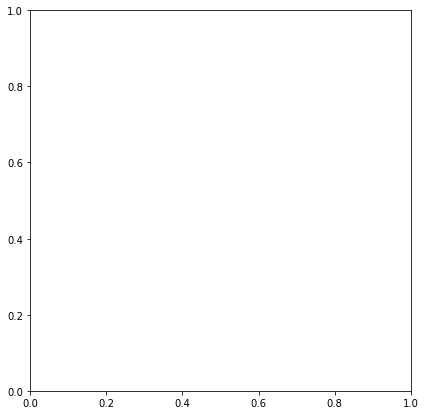

In [109]:
# Combined many FP clips and 1 TP clip into new long clips [old needs to be updated]:

#Generate MANY new long clips--for each TP, select 9 random FP and randomly concatenate together (approximating 60s clip)
dest=TRAIN_AUDIO_ROOT.joinpath('gen_full_tpfp')
if dest.exists()==False:
    os.mkdir(dest)
    #D:\rfcx-species-audio-detection\train\fp_clips\FP_8_00204008d.png
tp=[png for png in TRAIN_AUDIO_ROOT.joinpath('tp_clips').glob('*.png')]
fp=[str(png) for png in TRAIN_AUDIO_ROOT.joinpath('fp_clips').glob('*.png')]
fig, ax = plt.subplots(figsize=(15, 7))
for i,p in enumerate(tp):
    tp_img=rgb2gray(io.imread(p)[:,:,0:3])
    spec=p.parts[-1].split('_')[1]
    rec=p.parts[-1].split('_')[2].split('.')[0]
    use=list(np.random.permutation(24)) # random list of possible FP to include
    use=[s for s in use if s != int(spec)] #exclude FP equal to TP 
    use=use[0:9]
    put_spec=np.random.randint(0,len(use))
    use[put_spec]=int(spec)
    new_fn='TP_%s_%s_FP' % (spec,rec)
    print('Processing %s'% new_fn)
    for j,fp_spec in enumerate(use):
        new_fn=new_fn + '_%d' % fp_spec
        if fp_spec == int(spec):
            #Load TP to this slot
            im=tp_img
        else:
            #Randomly select from available FP of desired species and load im
            fp_rec=df_fp.index[df_fp['species_id']==fp_spec]
            use_fp=fp_rec[np.random.randint(0,len(fp_rec))]
            fpfn=[fn for fn in fp if use_fp in fn][0]
            im=rgb2gray(io.imread(fpfn)[:,:,0:3])
        if j==0:
            a=im
        else:
            a=np.concatenate((a,im),axis=1)
    new_fn = new_fn + '.png'
    img_pnfn=dest.joinpath(new_fn)
    print('\tSaving to %s' % img_pnfn)
    #Plot concatenated spectogram
    plt.imshow(a,cmap='bwr')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(img_pnfn,dpi=250,pad_inches=0,bbox_inches='tight', transparent=True)
    time.sleep(0.1)
    plt.cla()

In [103]:
fp_spec=23
spec=3
use0=list(np.random.permutation(24)) # random list of possible FP to include
use1=[s for s in use0 if s != int(spec)] #exclude FP equal to TP 
use2=use1[0:9]
put_spec=np.random.randint(0,len(use2))
use3=use2
use3[put_spec]=spec
use3

[2, 17, 20, 21, 0, 9, 22, 3, 16]

In [89]:
[s for s in use0 if s != int(spec)]

[11,
 17,
 21,
 22,
 8,
 15,
 2,
 12,
 23,
 16,
 20,
 9,
 4,
 19,
 14,
 13,
 1,
 18,
 6,
 10,
 0,
 5,
 7]

In [ ]:
#Copy tp and fp into species-specific folders:
start_dirs=['tp_clips','fp_clips']
for d in start_dirs:
    src=TRAIN_AUDIO_ROOT.joinpath(d)
    pngs=[png for png in src.glob('*.png')]
    for png in pngs:
        fn=png.parts[-1]
        spec=fn.split('_')[1]
        dest = TRAIN_AUDIO_ROOT.joinpath('spec').joinpath(spec)
        if dest.exists()==False:
            os.mkdir(dest)
        #print('From %s to %s' % (png,dest))
        shutil.copy(str(png),dest)
print('Finished')

In [ ]:
#Move FP clips spectrograms from species-based folders into tp_clips data folder:
for spec in np.unique(df_fp['species_id']):
    path = TRAIN_AUDIO_ROOT.joinpath('%d' % spec)
    pngs=[png for png in path.glob('*.png')]
    for png in pngs:
        fn=png.parts[-1]
        tp=fn.split('_')[0]
        if tp == 'FP':
            print(png)
            shutil.move(str(png),str(TRAIN_AUDIO_ROOT.joinpath('tp_clip')))

In [ ]:
#Copy tp clips into tp_clips:
start_dirs=['tp_clips_and_full',]
for d in start_dirs:
    src=TRAIN_AUDIO_ROOT.joinpath(d)
    pngs=[png for png in src.glob('*.png')]
    for png in pngs:
        fn=png.parts[-1]
        p=fn.split('_')
        if len(p) >= 4:
            is_full=p[3] == 'full.png'
        dest = TRAIN_AUDIO_ROOT.joinpath('tp_clips').joinpath(fn)
        if not is_full:`
            print('From %s to %s' % (png,dest))
            shutil.copy(str(png),dest)
print('Finished')